# Reconstructing out-of-sample DVs

Given a quantitative ontology, or psychological space, that DVs can be projected into, how can we deterine the embedding of new variables?

Currently, our embedding is determined by factor analysis. Thus ontological embedding are only known for the DVs entered into the original model. How could we extend this?

One possibility is measuring new variables in the same population that completed our original battery. After doing this we could either (1) run the model anew, or (2) use linear regression to map the already discovered factors onto the new variables. The former is better, but results in small changes to the actual factors with each new variable. The latter method ensures that our factors stay the same. Neither is scalable, however, as we do not, in general, have access to a constant population that can be remeasured whenever new measures come into the picture.

Another possibility that works with new populations requires that the new population completes the entire battery used to estimate the original factors, in addition to whatever new variables are of interest. Doing so allows the calculation of factor scores for this new population based on the original model, which can then be mapped to the new measures of interest. This allows researchers to capitalize on the original model (presumably fit on more subjects than the new study), while expanding the ontology. Problems exist here, however.
- The most obvious problem is that you have to measure the new sample on the entire battery used to fit the original EFA model. Given that this takes many hours (the exact number depending on whether tasks, surveys or both are used), this is exceedingly impractical. In our cas we did have our new fMRI sample take the entire battery (or at least a subset of participants), so this problem isn't as relevant
- Still problems remain. If N is small, the estimate of the ontological embedding for new DVs is likely unstable.

This latter problem necessitates some quantitative exploration. This notebook simulates the issue by:
1. Removing a DV from the original ontology dataset
2. Performing EFA on this subset
3. Using linear regression to map these EFA factors to the left out variable

(3) is performed on smaller population sizes to reflect the reality of most studies (including ours) and is repeated to get a sense of the mapping's variability

### Small issues not currently addressed

- The EFA model is fit on the entire population. An even more stringent simulation would subset the subjects used in the "new study" and fit the EFA model on a completely independent group. I tried this once - the factor scores hardly differed. In addition, I want the EFA model to be as well-powered as possible, as that will be the reality for this method moving forward
- I am currently not holding out entire tasks, but only specific DVs

In [1]:
import argparse
from glob import glob
import numpy as np
from os import makedirs, path
import pandas as pd
import pickle
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import normalize 

from dimensional_structure.EFA_plots import get_communality
from dimensional_structure.reconstruction_plots import (plot_factor_reconstructions,
                                                       plot_reconstruction_hist)
from dimensional_structure.reconstruction_utils import (get_reconstruction_results, 
                                                        linear_reconstruction,
                                                        k_nearest_reconstruction)
from selfregulation.utils.plot_utils import format_num
from selfregulation.utils.result_utils import load_results
from selfregulation.utils.utils import get_recent_dataset, get_info, get_retest_data

Using TensorFlow backend.
/media/Data/Ian/miniconda/envs/SRO/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# argparse
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('-pop_sizes', nargs='+', default=[25, 50, 100, 400], type=int)
    parser.add_argument('-n_reps', default=200)
    parser.add_argument('-n_measures', default=None, type=int)
    parser.add_argument('-dataset', default=None)
    parser.add_argument('-rerun', action='store_true')
    parser.add_argument('-append', action='store_true')
    parser.add_argument('-EFA_rotation', default='oblimin')
    parser.add_argument('-verbose', action='store_true')
    args, _ = parser.parse_known_args()
    pop_sizes = args.pop_sizes
    n_reps = args.n_reps
    n_measures = args.n_measures
    rerun = args.rerun
    append = args.append
    EFA_rotation = args.EFA_rotation
    verbose = args.verbose
    if args.dataset is not None:
        dataset = args.dataset
    else:
        dataset = get_recent_dataset()

In [3]:
# additional setup
np.random.seed(12412)
results = load_results(dataset)['task']
retest_data = get_retest_data(dataset.replace('Complete', 'Retest'))
c = results.EFA.results['num_factors']

classifiers = {'Ridge': Ridge(fit_intercept=False),
               'LR': LinearRegression(fit_intercept=False)}
# get output dir to store results
output_dir = path.join(get_info('results_directory'),
                       'ontology_reconstruction', results.ID, EFA_rotation)
makedirs(output_dir, exist_ok=True)
# get plot dir to store plots
plot_dir = path.join(output_dir, 'Plots')
makedirs(plot_dir, exist_ok=True)

/media/Data/Ian/miniconda/envs/SRO/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# get a random subset of variables to perform the calculation on if n_vars is set
measures = np.unique([i.split('.')[0] for i in results.data.columns])
if n_measures is not None:
    measure_list = np.random.choice(measures, n_measures, replace=False)
else:
    measure_list = measures
# get all variables from selected tasks
var_list = results.data.filter(regex='|'.join(measure_list)).columns

In [5]:
def load_files(reconstruction_files, query_string=None):
    out = {}
    for f in reconstruction_files:
        tmp = pd.read_pickle(f)
        if query_string:
            tmp = tmp.query(query_string)
        name = f.split('-')[-1][:-4]
        out[name] = tmp
    return out

def update_files(old, new):
    for k, df in old.items():
        add = new.pop(k)
        add = add.query('label == "partial_reconstruct"')
        add.loc[:,'rep'] += df.rep.max()
        old[k] = pd.concat([df, add], sort=False).reset_index(drop=True)
    old.update(new)
        
def combine_files(reconstruction_files, query_string=None):
    if type(reconstruction_files) != dict:
        out = load_files(reconstruction_files, query_string)
    else:
        out = reconstruction_files
    return pd.concat(out, sort=False).reset_index(drop=True)

def normalize_reconstruction(reconstruction, c, inplace=True):
    """ Ensures reconstructions lie on the unit circle """
    if not inplace:
        reconstruction = reconstruction.copy()
    normed = normalize(reconstruction.iloc[:,:c])
    reconstruction.iloc[:,:c] = normed
    if not inplace:
        return reconstruction
    

Run simulation for every variable at different population sizes. 

That is, do the following:

1. take a variable (say stroop incongruent-congruent RT), remove it from the data matrix
2. Run EFA on the data matrix composes of the 522 (subject) x N-1 (variable) data matrix
3. Calculate factor scores for all 522 subjects
4. Select a subset of "pop_size" to do an "ontological mapping". That is, pretend that these subjects did the whole battery (missing the one variable) *and then* completed one more task. The idea is we want to do a mapping from those subject's factor scores to the new variable
   1. We can do a linear mapping (regression) from the ontological scores to the output variable
   2. We can do a k-nearest neighbor interpolation, where we say the unknown ontological factor is a blend of the "nearest" variables in the dataset
5. Repeat (4) a number of times to get a sense for the accuracy and variability of that mapping
6. Compare the estimated ontological scores for the held out var (stroop incongruent-congruent) to the original "correct" ontological mapping (that would have been obtained if the variable was included in the original data matrix

## Perform reconstruction

### K Nearest Neighbor Reconstruction

In [9]:
%%time
k_list = list(range(1,20))
basename = path.join(output_dir, 'k_reconstruct*')
files = glob(basename)
updated = []
if rerun: # rerun everything
    regex_list = ['^'+m for m in measure_list]
    k_reconstructions=get_reconstruction_results(results, regex_list, pop_sizes, 
                                                 n_reps=n_reps, 
                                                 recon_fun=k_nearest_reconstruction, 
                                                 k_list=k_list, 
                                                 EFA_rotation=EFA_rotation,
                                                 verbose=verbose)
    updated = measure_list
else:
    k_reconstructions = load_files(files)
    if append: # add more simulations to previous files
        regex_list = ['^'+m for m in measure_list]
        to_append = get_reconstruction_results(results, regex_list, pop_sizes, 
                                                n_reps=n_reps, 
                                                recon_fun=k_nearest_reconstruction, 
                                                k_list=k_list, 
                                                EFA_rotation=EFA_rotation,
                                               verbose=verbose)
        updated = list(to_append.keys())
        update_files(k_reconstructions, to_append)
    else: # load previous files and add run any additional ones required
        tmp_measures = set(measure_list) - set(k_reconstructions.keys())
        regex_list = ['^'+m for m in tmp_measures]
        additional = get_reconstruction_results(results, regex_list, pop_sizes, 
                                                n_reps=n_reps, 
                                                recon_fun=k_nearest_reconstruction, 
                                                k_list=k_list, 
                                                EFA_rotation=EFA_rotation,
                                                verbose=verbose)
        k_reconstructions.update(additional)
        updated = additional.keys()

for measure in updated:
    df = k_reconstructions[measure]
    df.to_pickle(basename[:-1]+'-%s.pkl' % measure)

CPU times: user 9.46 s, sys: 868 ms, total: 10.3 s
Wall time: 11.1 s


In [10]:
var_summary = pd.DataFrame()
for measure, reconstruction in k_reconstructions.items():
    tmp_summary = reconstruction.query('label=="partial_reconstruct"') \
                    .groupby(['pop_size', 'k', 'weighting','var'])['corr_score'].mean().reset_index()
    var_summary = pd.concat([var_summary, tmp_summary])

In [11]:
k_summary = var_summary.groupby(['pop_size', 'k', 'weighting']).mean()
# summarize further
k_best_params = {}
for pop_size in pop_sizes:
    tmp=k_summary.query('pop_size == %s' % pop_size)
    best_params = tmp.idxmax()[0]
    best_val = tmp.loc[best_params][0]
    k_best_params[pop_size] = {'k': best_params[1], 
                               'weighting': best_params[2],
                               'best_val': best_val}

In [12]:
reconstruction_list = []
for reconstruction in k_reconstructions.values():
    true = reconstruction.query('label == "true"')
    reconstruction_list.append(true)
    for k, v in k_best_params.items():
        tmp_partial = reconstruction.query('pop_size == %s and \
                                     k == %s and \
                                     weighting == "%s"' % (k, v['k'], v['weighting']))
        full = reconstruction.query('label == "full_reconstruct" and \
                                     k == %s and \
                                     weighting == "%s"' % (v['k'], v['weighting']))
        reconstruction_list += [tmp_partial, full]

k_best_reconstruction = pd.concat(reconstruction_list, axis=0, sort=False)
k_best_reconstruction.query('label=="partial_reconstruct"') \
    .groupby('pop_size')['corr_score'].agg(['mean','std'])

,mean,std
pop_size,,
25.0,0.576401,0.404751
50.0,0.678992,0.344809
100.0,0.760416,0.287298
400.0,0.862184,0.169630


In [13]:
del k_reconstructions

### Linear Reconstruction

In [14]:
%%time
clfs = {'Linear': LinearRegression(fit_intercept=False),
       'RidgeCV': RidgeCV(fit_intercept=False, cv=10)}
linear_reconstructions = {}
for clf_name, clf in clfs.items():
    basename = path.join(output_dir, 'linear-%s_reconstruct*' % clf_name)
    files = glob(basename)
    updated = []
    if rerun: # rerun everything
        regex_list = ['^'+m for m in measure_list]
        tmp_reconstructions=get_reconstruction_results(results, regex_list, pop_sizes, 
                                                       n_reps=n_reps, 
                                                       recon_fun=linear_reconstruction, 
                                                       clf=clf,
                                                       EFA_rotation=EFA_rotation,
                                                       verbose=verbose)
        updated = measure_list
    else:
        tmp_reconstructions = load_files(files)
        if append: # add more simulations to previous files
            regex_list = ['^'+m for m in measure_list]
            to_append = get_reconstruction_results(results, regex_list, pop_sizes, 
                                                       n_reps=n_reps, 
                                                       recon_fun=linear_reconstruction, 
                                                       clf=clf,
                                                       EFA_rotation=EFA_rotation,
                                                       verbose=verbose)
            updated = list(to_append.keys())
            update_files(tmp_reconstructions, to_append)
        else: # load previous files and add run any additional ones required
            tmp_measures = set(measure_list) - set(tmp_reconstructions.keys())
            regex_list = ['^'+m for m in tmp_measures]
            additional = get_reconstruction_results(results, regex_list, pop_sizes, 
                                                    n_reps=n_reps, 
                                                    recon_fun=linear_reconstruction, 
                                                    clf=clf,
                                                    EFA_rotation=EFA_rotation,
                                                    verbose=verbose)
            tmp_reconstructions.update(additional)
            updated = additional.keys()

    for measure in updated:
        df = tmp_reconstructions[measure]
        df.to_pickle(basename[:-1]+'-%s.pkl' % measure)
        
    files = glob(basename)
    if len(files) > 0:
        linear_reconstructions[clf_name] = combine_files(files)

CPU times: user 156 ms, sys: 16 ms, total: 172 ms
Wall time: 272 ms


In [15]:
summary = pd.DataFrame()
for clf, df in linear_reconstructions.items():
    tmp = df.query('label=="partial_reconstruct"') \
        .groupby('pop_size').corr_score.agg([np.mean, np.std])
    tmp.loc[:,'clf'] = clf
    summary = pd.concat([summary, tmp], sort=False)
print(summary)

              mean       std      clf
pop_size                             
25.0      0.555906  0.404597   Linear
50.0      0.695724  0.340813   Linear
100.0     0.801878  0.275575   Linear
400.0     0.945179  0.162202   Linear
25.0      0.578481  0.390866  RidgeCV
50.0      0.700274  0.337025  RidgeCV
100.0     0.801370  0.270260  RidgeCV
400.0     0.946065  0.140955  RidgeCV


In [213]:
reconstructions = {'KNN': k_best_reconstruction,
                   'RidgeCV': linear_reconstructions['RidgeCV']}

## Statistics

In [214]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [215]:
# variable characteristics
all_vars = sorted(k_best_reconstruction['var'].unique())
retest_index = [i.replace('.logTr','').replace('.ReflogTr','') for i in all_vars]
retest_vals = retest_data.loc[retest_index,'icc']
retest_vals.index = all_vars
communality = get_communality(results.EFA)
communality.index = all_vars
avg_corr  = results.data.corr().replace(1,0).mean()
avg_corr.name = "avg_correlation"

In [216]:
# create summaries
additional = pd.concat([retest_vals, communality, avg_corr], axis=1)
reconstruction_summaries = {}
for name, reconstruction in reconstructions.items():
    s = reconstruction.query('label == "partial_reconstruct"') \
        .groupby(['var', 'pop_size']).corr_score.agg(['mean', 'std'])
    s = s.reset_index().join(additional, on='var')
    reconstruction_summaries[name] = s
all_reconstructions = pd.concat(reconstruction_summaries).reset_index()
all_reconstructions = all_reconstructions.rename({'level_0': 'approach'}, axis=1).drop('level_1', axis=1)

In [225]:
to_fit = all_reconstructions.copy()
to_fit.loc[:, 'mean'] = np.arctanh(to_fit['mean'])
md = smf.mixedlm("mean ~ pop_size*C(approach, Treatment(reference='KNN'))", data=to_fit, groups=to_fit['var'])
mdf = md.fit()
print(mdf.summary())

                                Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                mean     
No. Observations:                  1040                   Method:                            REML     
No. Groups:                        130                    Scale:                             0.0643   
Min. group size:                   8                      Likelihood:                        -281.6728
Max. group size:                   8                      Converged:                         Yes      
Mean group size:                   8.0                                                                
------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------
Int

In [220]:
models = {}
for name, reconstruction in reconstructions.items():
    reconstruction.query('label=="partial_reconstruct"') \
        .groupby('var')
    reconstruction.loc[:,'icc'] = reconstruction['var'].apply(lambda x: retest_vals.loc[x])
    reconstruction.loc[:,'communality'] = reconstruction['var'].apply(lambda x: communality.loc[x])
    reconstruction.loc[:,'avg_correlation'] = reconstruction['var'].apply(lambda x: avg_corr.loc[x])
    # fit model
    fit_data = reconstruction.query('label == "partial_reconstruct"')
    fit_data.loc[:, 'corr_score'] = np.arctanh(fit_data['corr_score'])
    md = smf.mixedlm("corr_score ~ pop_size + icc + avg_correlation", fit_data, groups=fit_data["var"])
    mdf = md.fit()
    models[name] = mdf
    if verbose:
        print('*'*79)
        print(name)
        print('*'*79)
        print(mdf.summary())

/media/Data/Ian/miniconda/envs/SRO/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


*******************************************************************************
KNN
*******************************************************************************
          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: corr_score 
No. Observations:  104000  Method:             REML       
No. Groups:        130     Scale:              0.2768     
Min. group size:   800     Likelihood:         -81183.8565
Max. group size:   800     Converged:          Yes        
Mean group size:   800.0                                  
----------------------------------------------------------
                Coef. Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       0.596    0.098   6.107 0.000  0.404  0.787
pop_size        0.001    0.000 137.554 0.000  0.001  0.002
icc             0.412    0.175   2.346 0.019  0.068  0.756
avg_correlation 9.356    1.164   8.039 0.000  7.075 11.636
groups RE       0.172

## Visualization

Of concern is the average correspondence and variability between the estimated ontological fingerprint of a DV and its "ground-truth" (the original estimate when it was part of the EFA model)

One way to look at this is just the average reconstruction score (e.g., for example) and variability of reconstruction score as a function of pseudo-pop-size and model parameters

In [221]:
%matplotlib inline
# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
colors = sns.color_palette('Set1', n_colors = len(pop_sizes), desat=.8)

### Overall Performance

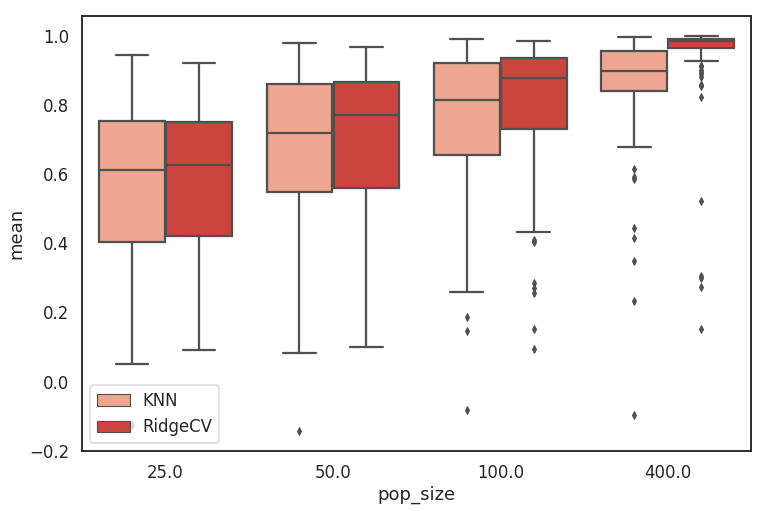

In [222]:
f = plt.figure(figsize=(12,8))
sns.boxplot(x='pop_size', y='mean', hue='approach', data=all_reconstructions, palette='Reds')
plt.legend(loc='best')

### K Nearest Visualization (Example)

#### Average Performance by Model Parameters

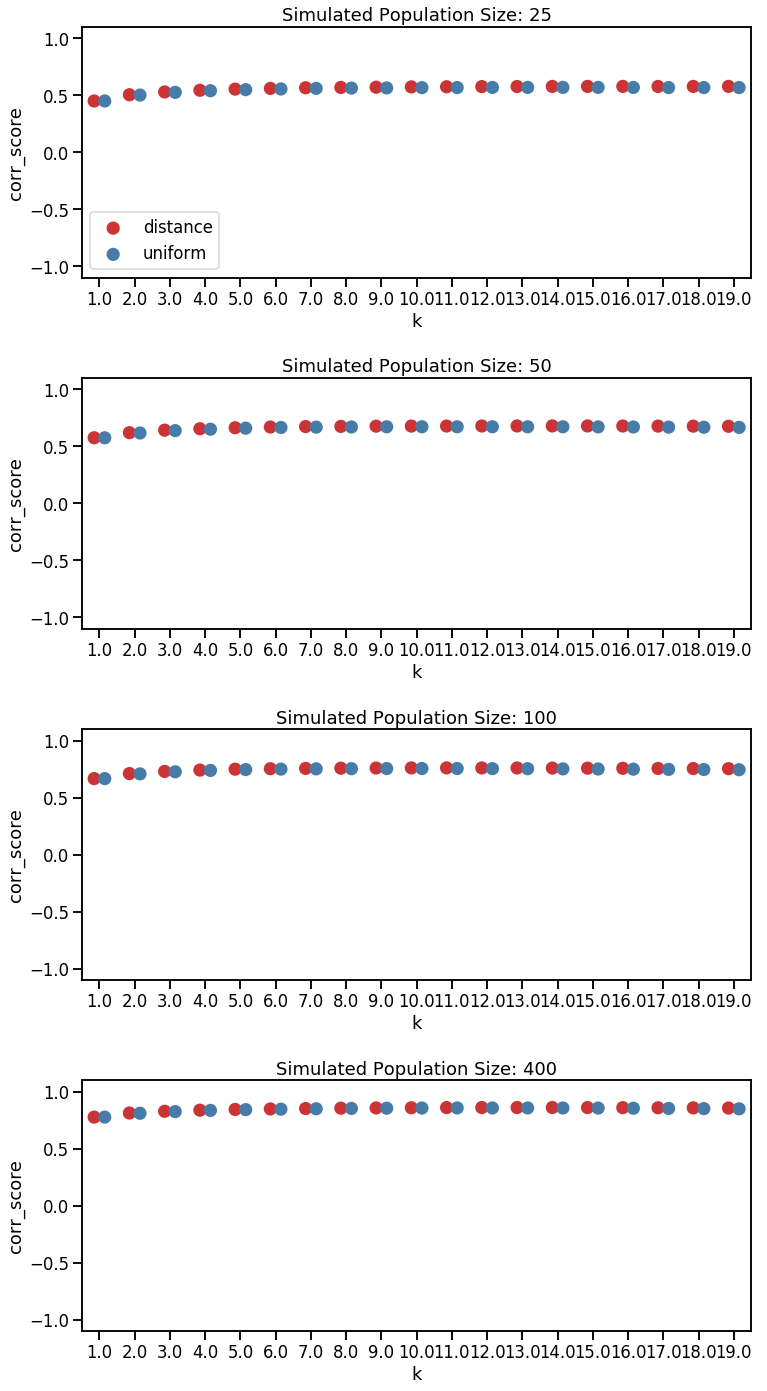

In [70]:
plot_df = k_summary.reset_index()
sns.set_context('talk')
n_cols = 1
n_rows = len(pop_sizes)//n_cols
f, axes = plt.subplots(n_rows, n_cols, figsize=(12,n_rows*6))
axes = f.get_axes()
legend_on=True
for ax, pop_size in zip(axes, pop_sizes):
    sns.pointplot(x='k', y='corr_score', hue='weighting', 
                data=plot_df.query('pop_size==%s' % pop_size),
                ax=ax, dodge=.3, alpha=.75, join=False, ci=None)
    ax.set_title('Simulated Population Size: %s' % pop_size)
    ax.set_ylim(-1.1,1.1)
    ax.legend().set_visible(legend_on)
    legend_on=False
plt.subplots_adjust(hspace=.4)

#### Performance for each DV

Only taking the best parameters from the k-nearest neighbor algorithm

##### Histogram of DV reconstruction scores

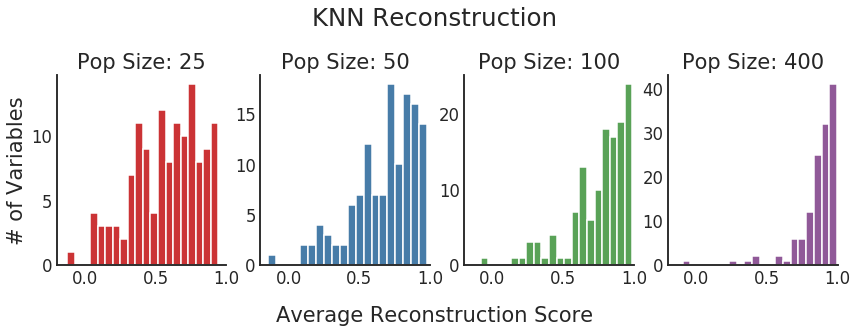

In [71]:
plot_reconstruction_hist(k_best_reconstruction, title='KNN Reconstruction', size=14)

There is clearly a bit of variability in the reconstruction accuracy based on the variable itself. While this variability narrows with larger populations, it's still there, and there are a few variables that cannot be reconstructed at all

One possibility is that the least reliable variables are the worst reconstructed. Let's look at that...

##### Reconstruction score vs. Reliability

/media/Data/Ian/miniconda/envs/SRO/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


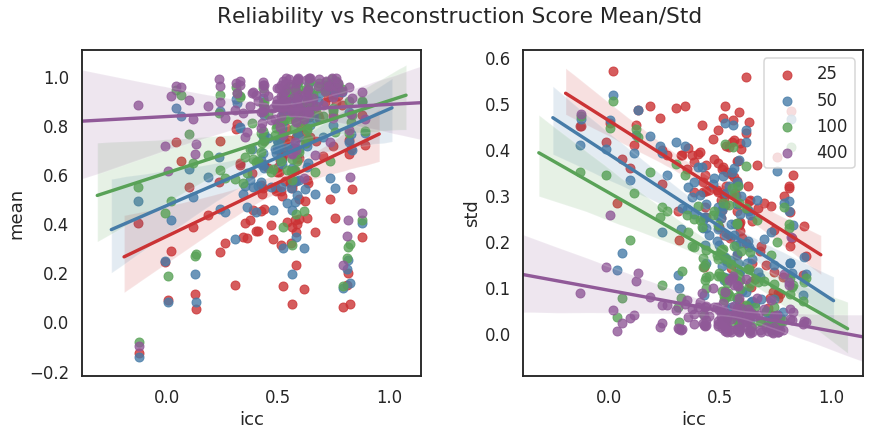

In [139]:
sns.set_context('talk')
f, axes = plt.subplots(1,2,figsize=(14,6))
for i, pop_size in enumerate(pop_sizes):
    sns.regplot('icc', 'mean', 
                data=reconstruction_summaries['KNN'].query('pop_size==%s' % pop_size), 
                label=pop_size, ax=axes[0], color=colors[i])
    sns.regplot('icc', 'std', 
                data=reconstruction_summaries['KNN'].query('pop_size==%s' % pop_size), 
                label=pop_size, ax=axes[1], color=colors[i])
axes[1].legend()
plt.suptitle('Reliability vs Reconstruction Score Mean/Std')
plt.subplots_adjust(wspace=.3)

We can dive in and look at one high/mediun/low reliable variable to see the reconstruction performance

In [73]:
sorted_retest_vals = retest_vals.sort_values().index
N = len(sorted_retest_vals)
high_var = sorted_retest_vals[N-1]
med_var = sorted_retest_vals[N//2]
low_var = sorted_retest_vals[0]

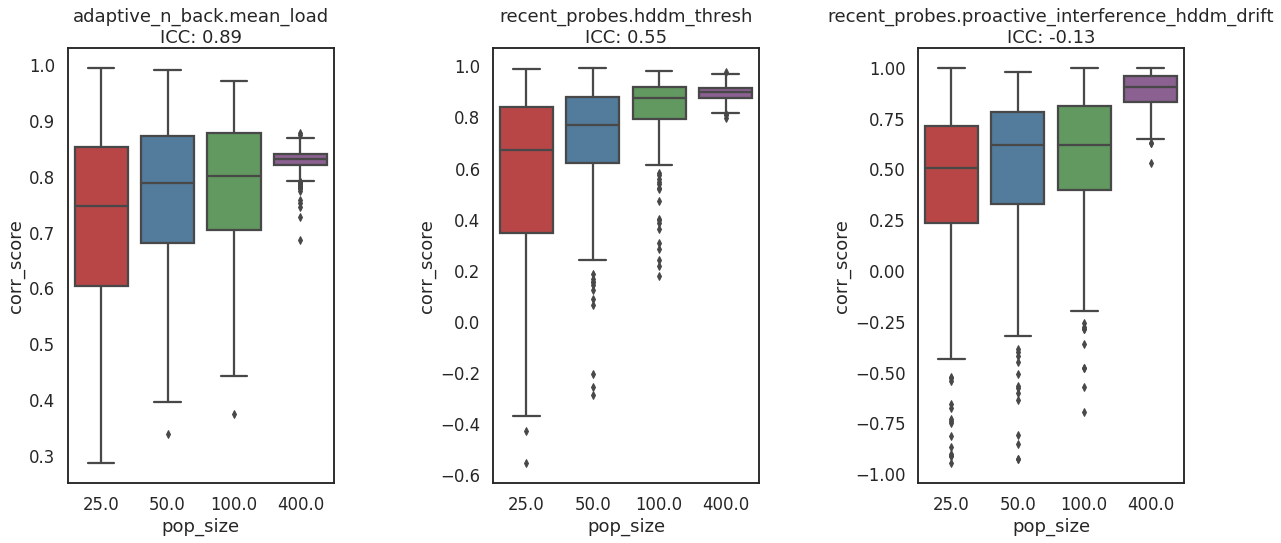

In [74]:
f, axes = plt.subplots(1,3, figsize=(20,8))
for ax, var in zip(axes, [high_var, med_var, low_var]):
    retest_in = var.replace('.logTr','').replace('.ReflogTr','')
    reliability = format_num(retest_data.loc[retest_in]['icc'])
    plot_df = k_best_reconstruction.query('var == "%s" and label=="partial_reconstruct"' % var)
    sns.boxplot(x='pop_size', y='corr_score', data=plot_df,  ax=ax)
    ax.set_title('%s\nICC: %s' % (var, reliability))
plt.subplots_adjust(wspace=.6)

So that doesn't seem to be the problem. Instead, what might be important is the DVs actual relationship to the ontology. That is, some DVs are better captured by the ontology to begin with. Maybe DVs "peripheral" to this particular ontology (not well captured by the space) are poorly reconstructed.

We can look at this by looking at the relationship between communality and DV reconstruction

##### Reconstruction Score vs Communality

/media/Data/Ian/miniconda/envs/SRO/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


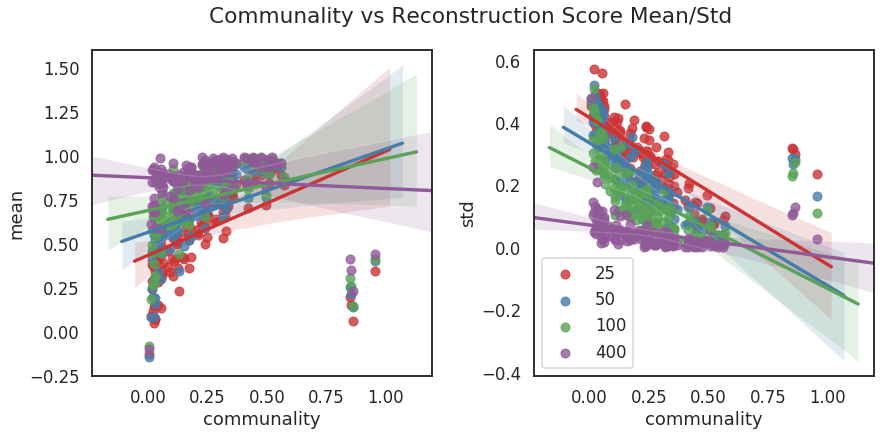

In [141]:
sns.set_context('talk')
f, axes = plt.subplots(1,2,figsize=(14,6))
for i, pop_size in enumerate(pop_sizes):
    sns.regplot('communality', 'mean', 
                data=reconstruction_summaries['KNN'].query('pop_size==%s' % pop_size), 
                label=pop_size, ax=axes[0], color=colors[i])
    sns.regplot('communality', 'std', 
                data=reconstruction_summaries['KNN'].query('pop_size==%s' % pop_size), 
                label=pop_size, ax=axes[1], color=colors[i])
axes[1].legend()
plt.suptitle('Communality vs Reconstruction Score Mean/Std')
plt.subplots_adjust(wspace=.3)

It seems clear that DVs with poor communality are not reconstructed well. A less "analysis based" way to think about this is reconstruction will be worse if you are far away from the other variables in the set.

##### Reconstruction Score vs Average Correlation

/media/Data/Ian/miniconda/envs/SRO/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


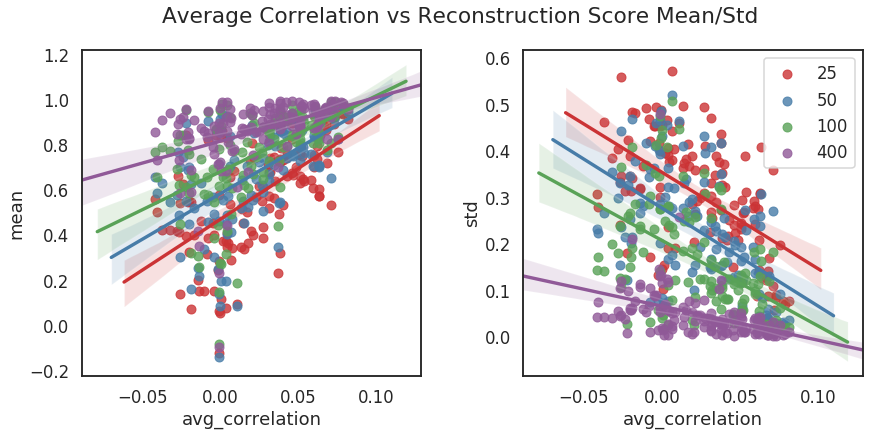

In [143]:
sns.set_context('talk')
f, axes = plt.subplots(1,2,figsize=(14,6))
for i, pop_size in enumerate(pop_sizes):
    sns.regplot('avg_correlation', 'mean', 
                data=reconstruction_summaries['KNN'].query('pop_size==%s' % pop_size), 
                label=pop_size, ax=axes[0], color=colors[i])
    sns.regplot('avg_correlation', 'std', 
                data=reconstruction_summaries['KNN'].query('pop_size==%s' % pop_size), 
                label=pop_size, ax=axes[1], color=colors[i])
axes[1].legend()
plt.suptitle('Average Correlation vs Reconstruction Score Mean/Std')
plt.subplots_adjust(wspace=.3)

It seems that the correlation with the overall dataset is important for reconstruction. All of this says that ontological mapping will be more successful if you have an a-priori reason to believe your new variable has something to do with the rest of the variables in the ontology. The weaker you believe that bond, the more data you should collect to articulate the connection

#### Visualization of Variability

##### Visualizing each factor's reconstruction separately

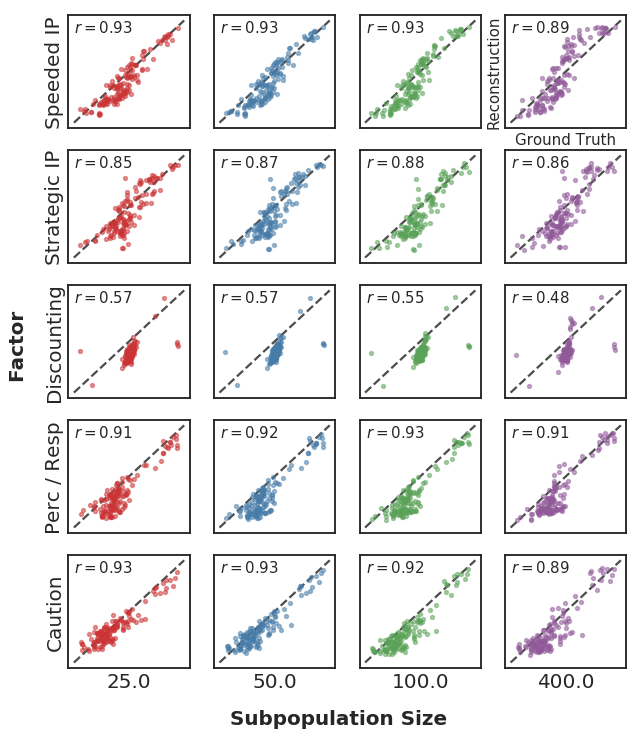

In [144]:
plot_factor_reconstructions(k_best_reconstruction, size=10)

##### Using TSNE

More complicate, we can visualize this by looking at the MDS plotting:
1. The original DVs
2. The "best" reconstruction using all the data
3. The n_reps simulated estimates with a smaller population size

In [231]:
def plot_reconstruction_2D(reconstructions, n_reps=None, 
                           reducer = TSNE(2, metric='precomputed'),
                           n_colored=5, use_background=False,
                           title=None, size=12, 
                           filename=None, dpi=300):
    if n_reps is None:
        n_reps = reconstructions.rep.max()
    
    var_list = reconstructions['var'].unique()
    colored_vars = np.random.choice(var_list, size=n_colored, replace=False)
    reconstructions = reconstructions[~(reconstructions.rep>n_reps)]
    reconstructions = reconstructions.query('label != "full_reconstruct"')
    if not use_background:
        reconstructions = reconstructions.query('var in %s' % list(colored_vars))

    pop_sizes = sorted(reconstructions.pop_size.dropna().unique())
    c = reconstructions.columns.get_loc('var') 
    # create reduced representation
    reduced = []
    for pop_size in pop_sizes:
        subset = reconstructions.query('label=="true" or pop_size == %s'% pop_size)
        subset = subset.iloc[:, :c]
        distances = squareform(pdist(subset, metric='correlation'))
        reduced.append(reducer.fit_transform(distances))
        
    N_pop = len(pop_sizes)
    # get colors
    tmp_subset = reconstructions.query('label=="true" or pop_size == %s'% pop_sizes[-1]).reset_index(drop=True)
    base_colors = sns.color_palette(palette='hls', n_colors=len(colored_vars))
    color_map = {k:v for k,v in zip(colored_vars, base_colors)}
    colored_indices = tmp_subset[tmp_subset['var'].isin(colored_vars)].index
    color_list = list(tmp_subset.loc[colored_indices,'var'].apply(lambda x: color_map[x]))
    colored_sizes = [300 if x=='true' else 75 for x in tmp_subset.loc[colored_indices,'label']]
    uncolored_indices = list(set(tmp_subset.index) - set(colored_indices))
    # plot scatter
    f,axes = plt.subplots(N_pop,1,figsize=(12,12*N_pop))
    for ax, red, pop_size in zip(axes, reduced, pop_sizes):
        ax.scatter(red[uncolored_indices,0], red[uncolored_indices,1], s=10, c=[.5,.5,.5], alpha=.5)
        ax.scatter(red[colored_indices,0], red[colored_indices,1], s=colored_sizes,
                   c=color_list, edgecolor='black', linewidth=2, alpha=.75)
        ax.set_title('Pseudo-Population Size: %s' % pop_size)

    if title:
        f.suptitle(title, y=1.15, size=size*1.75)
    if filename is not None:
        save_figure(f, filename, {'bbox_inches': 'tight', 'dpi': dpi})
        plt.close()

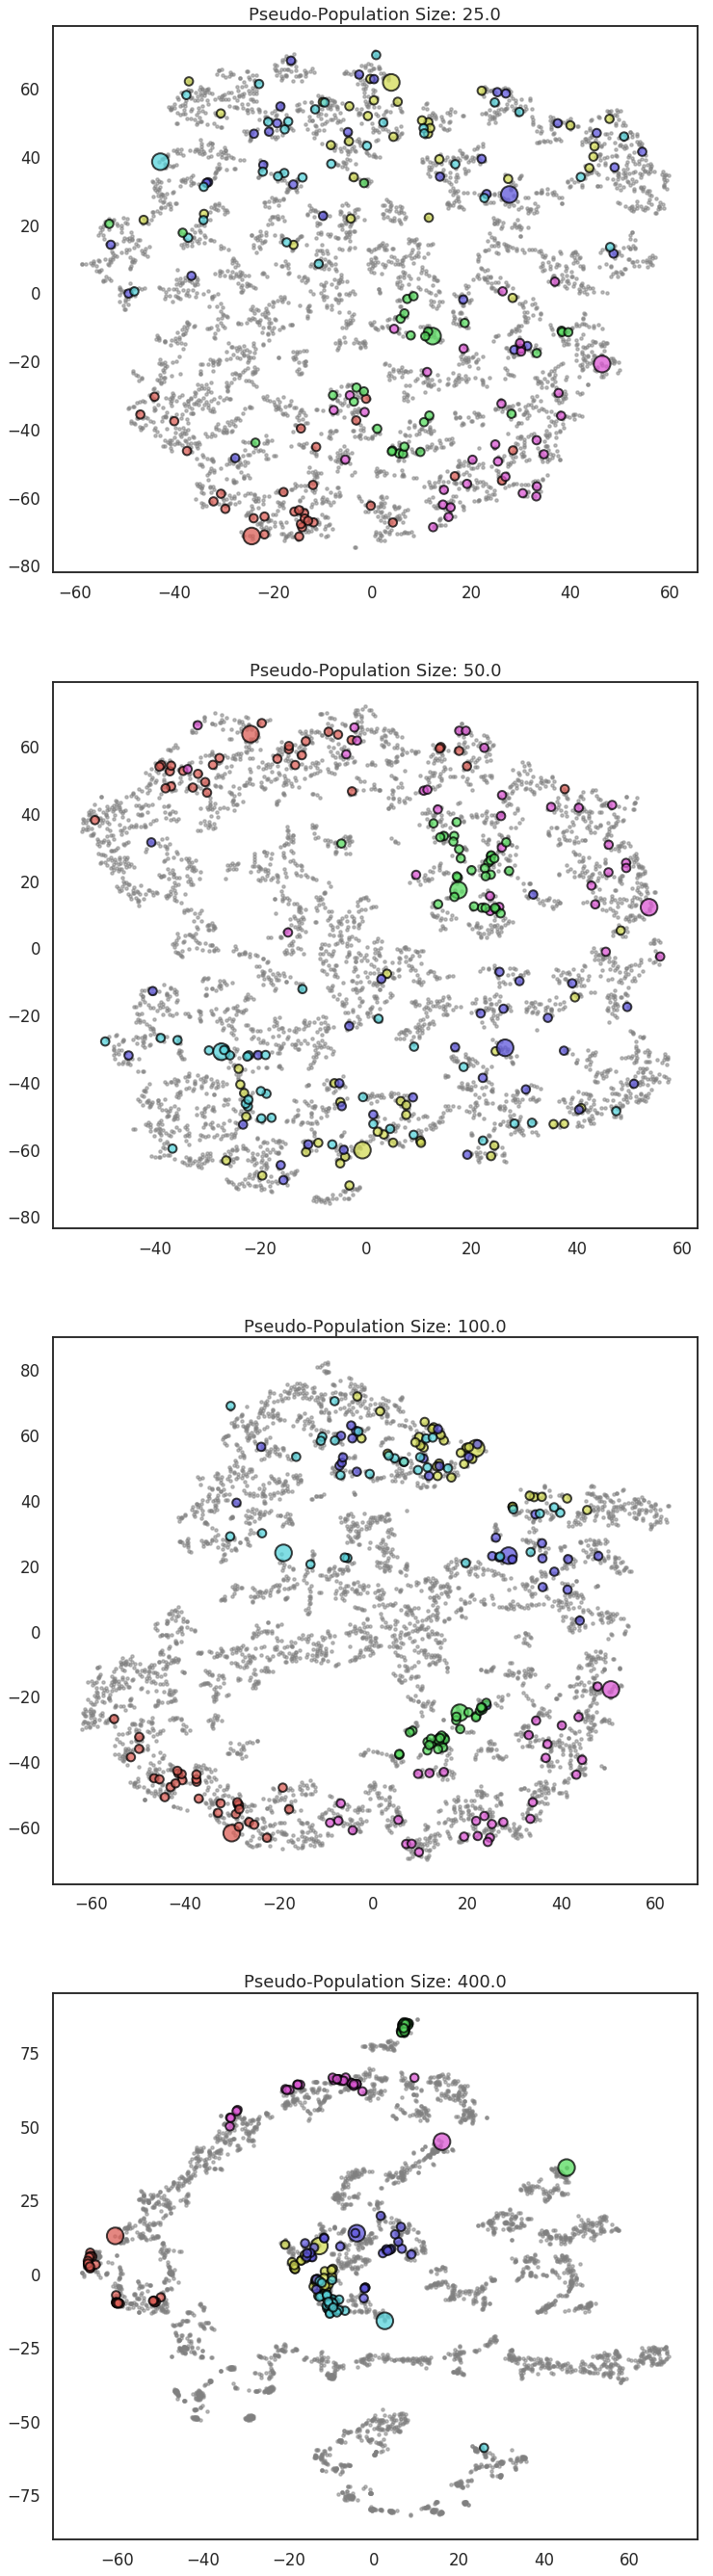

In [232]:
plot_reconstruction_2D(k_best_reconstruction, n_reps=30, n_colored=6, use_background=True)

### Save Visualizations

In [ ]:
for name, reconstruction in reconstructions.items():
    plot_reconstruction_hist(reconstruction, title='KNN Reconstruction', size=14,
                            filename=path.join(plot_dir, name+'_recon_hist.pdf'))
    plot_factor_reconstructions(reconstruction, size=10,
                               filename=path.join(plot_dir, name+'_factor_recon.pdf'))

## Reduced Reconstruction using fewer contextualizing variables